<a href="https://colab.research.google.com/github/MikelKN/Counternarratives_milanlp/blob/main/Counter_hateeval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers pandas matplotlib tqdm --upgrade --quiet
!pip install cohere --quiet
!pip install -U kaleido --quiet

import cohere
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
import torch
import torch.nn.functional as F
import plotly.graph_objects as go
import random

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["OPEN_AI"] = userdata.get("OPEN_AI")
os.environ["HF_API_KEY"] = userdata.get("HF_API_KEY")
os.environ["COHERE_API"] = userdata.get("COHERE_API")

HF_TOKEN = userdata.get("HF_API_KEY")

!pip install --upgrade openai transformers --quiet
from openai import OpenAI

from pathlib import Path

path = Path('/content/drive/MyDrive/PhD with Rawat/milanlp/analysis/outputs')
analysis_path = '/content/drive/MyDrive/PhD with Rawat/milanlp/analysis'

class Stats():
    def __init__ (self, colors= ['skyblue', 'salmon', 'green', 'red', 'orange', 'blue' ], figsize = (7, 4)):
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.figsize = figsize
      self.colors = colors

    def exploratory_data_analysis(self, data, text):
      data[f'{text}_length'] = data[text].str.len() #gives an idea of the overall character size of the text.
      data[f'{text}_word_count'] = data[text].str.len() if text else 0 #focuses on the number of words or tokens.
      # provides insights into how long the words are on average.
      data[f'{text}_mean_word_length'] = data[text].apply(lambda x: np.mean([len(word) for word in str(x).split() if word])) if text else 0
      return data

    def plot_mean_word_length(self, dataset, dataset_names, image_name):
      results_df = pd.DataFrame({
          "Dataset": [dataset_name for dataset_name in dataset_names],
          "Mean Word Length": [dataset[f'{dataset_name}_word_count'].mean() for dataset_name in dataset_names]
      })
      plt.figure(figsize=self.figsize)
      plt.barh(results_df["Dataset"], results_df["Mean Word Length"], color=self.colors[:len(dataset_names)])
      plt.ylabel("dataset")
      plt.xlabel("Mean Word Length")
      plt.title("Mean Word Length Comparison")
      plt.tight_layout()
      plt.savefig(path/image_name)
      plt.show()

# docu:https://huggingface.co/SamLowe/roberta-base-go_emotions
class BERTemotion():
    def __init__(self, emotion_colors=None, max_length = 512, batch_size = 5, task ="text-classification",  sent_model_name="SamLowe/roberta-base-go_emotions"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(sent_model_name)
        self.classifier = pipeline(task="text-classification", model=sent_model_name, top_k=True, device=0 if torch.cuda.is_available() else -1)
        self.emotion_colors = {
                      "admiration": "gold",
                      "anger": "cadetblue",
                      "approval": "orange",
                      "caring": "pink",
                      "curiosity": "darkviolet",
                      "desire": "cornflowerblue",
                      "disappointment": "bisque",
                      "disapproval": "moccasin",
                      "disgust": "silver",
                      "love": "turquoise",
                      "neutral": "tomato",
                      "optimism": "yellow",
                      "sadness": "pink"
                  }

    def predict(self, texts):
        truncated_texts = [
            self.tokenizer.decode(
                self.tokenizer(text, truncation=True, max_length=self.max_length)['input_ids'],
                skip_special_tokens=True)
            for text in texts
        ]

        # batch processing for better GPU efficiency
        model_outputs = self.classifier(truncated_texts, batch_size=self.batch_size)
        results = []
        for output in model_outputs:
            top_emotion = output[0]
            results.append({
                "emotion": top_emotion['label'],
                "emotion_score": top_emotion['score']
            })
        return results

    def random_color(self):
          return f"#{random.randint(0, 0xFFFFFF):06x}"

    def plot_emotion_distribution(self,dataset, emotion_columns, image_name, model_name='Roberta_Base_go', figsize=(20, 10)):
          emotion_counts = {col: dataset[col].value_counts() for col in emotion_columns}
          emotion_df = pd.DataFrame(emotion_counts).fillna(0).sort_index()
          emotion_dist = f"emotion_dict_{image_name}.png"
          emotion_df.plot(kind='barh', stacked=False, figsize=figsize, color=['green', 'blue', 'orange'])
          plt.title(f'{model_name} emotion Labels Distribution Across Datasets')
          plt.ylabel('Emotions')
          plt.xlabel('Counts')
          plt.legend(title="Data", loc='best')
          # plt.savefig(path/emotion_dist)
          plt.show()

    def emotion_counts(self, data):
      return data.value_counts().to_dict()

    def create_sankey_chart(self, data, dataset_name, col_name, path=path):
        emotion_count_dict = self.emotion_counts(data)
        all_emotions = list(emotion_count_dict.keys())
        nodes = all_emotions + [col_name]
        node_indices = {node: idx for idx, node in enumerate(nodes)}
        links = {
            "source": [],
            "target": [],
            "value": [],
            "color": []
        }
        for emotion, count in emotion_count_dict.items():
            links["source"].append(node_indices[emotion])
            links["target"].append(node_indices[col_name])
            links["value"].append(count)
            # links["color"].append(self.random_color())
            links['color'].append(self.emotion_colors.get(emotion.lower(), "black"))  # Default to gray if emotion not found


        fig = go.Figure(go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=nodes
            ),
            link=dict(
                source=links["source"],
                target=links["target"],
                value=links["value"],
                color=links["color"]
            )
        ))
        sankey_chart = f"{dataset_name}_sankey_chart_for_{col_name}.png"
        fig.update_layout(title_text=f"Emotion_Flow_for {col_name}", font_size=10)
        fig.write_image(path/sankey_chart)
        fig.show()

class Cohere_ai:
    def prompt_counter(self, event, model_name= 'command'):
      prompt = f"generate a counter-narrative to this hateful comment '{event}'. omit explanations and provide only the counter narrative"
      co_api = cohere.Client(userdata.get("COHERE_API"))
      response = co_api.chat(
          message=prompt,
          model=model_name,
          temperature=0.3
      )
      return response.text

class LLM_sentiment:

    def sentiment_gpt(self, event, model_name):
      prompt = f"classify this {event} as either positive or negative. omit all explanation and provide only the class"
      client = OpenAI(
          api_key = userdata.get("OPENAI_KEY"),
          )
      input = [{"role": "system", "content": "You are a helpful assistant."},
              {"role": "user","content": prompt,}]
      chat_completion = client.chat.completions.create(
          messages=input,
          model=model_name,
      )
      output = chat_completion.choices[0].message.content

      return output

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#counter narrative dataset

## merging vanilla and ngo

In [34]:
#vanilla counter
counter_vanilla_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/gpt4o_cohere_vanilla_prompt.csv', index_col=False)
columns = ['HATE_SPEECH', 'COUNTER_NARRATIVE', 'Cohere_prompt', 'model_completion']
new_name = ['counter_text', 'counternarrative', 'cohere_vanilla_prompt', 'gpt4o_vanilla_prompt']
rename_dict = dict(zip(columns, new_name))
counter_vanilla_df.rename(columns=rename_dict, inplace=True)

#ngo counter
counter_ngo_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/cohere_gpt4o_ngo_prompt.csv', index_col=False)
select_columns = counter_ngo_df[['cohere_ngo_prompt', 'gpt4o_ngo_prompt']]

# # merging both
# counter_df = pd.concat([counter_vanilla_df,select_columns], axis=1)
# counter_df.reset_index(drop=True, inplace=True)
# file_name = f'final_counter_cohere_gpt4o_prompt.csv'
# file_path = os.path.join(analysis_path, file_name)
# counter_df.to_csv(file_path, index=False)
# counter_df.head()

,INDEX,counter_text,counternarrative,TARGET,VERSION,gpt4o_vanilla_prompt,cohere_vanilla_prompt,cohere_ngo_prompt,gpt4o_ngo_prompt
0,1619,This invasion is not acceptable at all!,Refugees are welcome. They are allowed to integrate and contribute to our society.,MIGRANTS,V3,"People moving and seeking new opportunities can enrich communities, bringing diverse perspectives and fostering mutual understanding.",We must accept the arrival of these newcomers with open arms and embrace the diversity and strengths that they bring to our community.,"We must foster an environment of inclusivity and respect for all, and recognize the importance of every individual regardless of their background, beliefs and ethnicity.","It's important to approach conflicts with empathy and understanding, recognizing the shared humanity in all individuals involved. Let's focus on dialogue, peace-building, and finding solutions that respect the dignity and rights of everyone affected."
1,3050,Faggots: you can buy your partner toys but you can't have sex with them.,"Sex is not only between a man and a woman, and if we're being honest, it's not heterosexual's place to decide how others have sex. This attitude only perpetuates violence against queer people and makes them victims.",LGBT+,V6_sbf,"Everyone has the right to love and express themselves freely. Love is a beautiful and personal experience, celebrated in diverse and meaningful ways by all individuals.","""Sex between adults of the same sex is equally as valid as sex between a man and a woman. It is 2023, and regardless of people's sexual orientations, consenting adults should have the freedom to explore their desires and express their sexual needs without judgment. The beauty of sexual diversity lies in its many forms, encompassing a wide range of delightful flavors and enchanting hues. Embrace the diversity of sexuality and celebrate the truth that everyone's sexual journey is unique and sp...","There are many different ways to respond to this hateful comment, and the most effective method will depend on the context in which it is being targeted. Here is one potential counter-narrative:\n\n""Sexuality and relationships are complex and varied experiences for everyone involved, and making assumptions or generalizations only serves to damage those involved and the broader LGBTQ+ community as a whole. It's crucial to promote acceptance and understanding, and to celebrate the beauty of di...","Everyone deserves love, respect, and the freedom to express their identity and relationships without judgment. Embracing diversity in love and relationships enriches our communities and fosters understanding and acceptance. Let's celebrate love in all its forms and support each other in living authentically and with dignity."
2,239,"Jews are different from non-Jews not because of their beliefs, but because of their physical nature. “Jewishness” and malevolence is inherited through blood.","A definition of Judaism based on physical or genetic traits is simply wrong. Through centuries of intermarriage and conversion, Jews from Eastern Europe tend to look like Eastern Europeans; Jews from Ethiopia tend to look like Ethiopians; Jews from India tend to look like Indians. And so on and so forth.",JEWS,V1,"All humans, regardless of their background or heritage, share the same fundamental humanity and dignity. Diversity among people enriches our world, and our differences in culture, belief, and tradition are to be celebrated, not used as a basis for division or prejudice. Every individual is unique, and character is shaped by personal choices and values, not by ancestry or ethnicity. Embracing empathy, understanding, and respect for all individuals fosters a more inclusive and harmonious society.","Jews are no different from non-Jews and everyone deserves equal opportunity and respect regardless of their religious beliefs, which should not be perceived as a flaw or an anomaly, but rather as a practice that has the right to e

# Part 1 and 2: Perfroming the same analysis on the CONAN Dataset and Hateeval (https://aclanthology.org/S19-2007/)

Device set to use cpu
<ipython-input-3-33b06adb42b8>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-33b06adb42b8>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy






 +++++++++++++++++++ COUNTER - NGO +++++++++++++++++++++++++



<ipython-input-3-33b06adb42b8>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-debb5dfd89cc>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 plotting word distribution



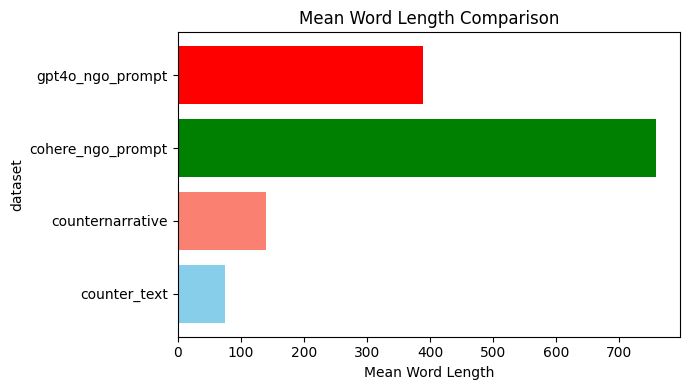


 plotting stats and emotions distribution



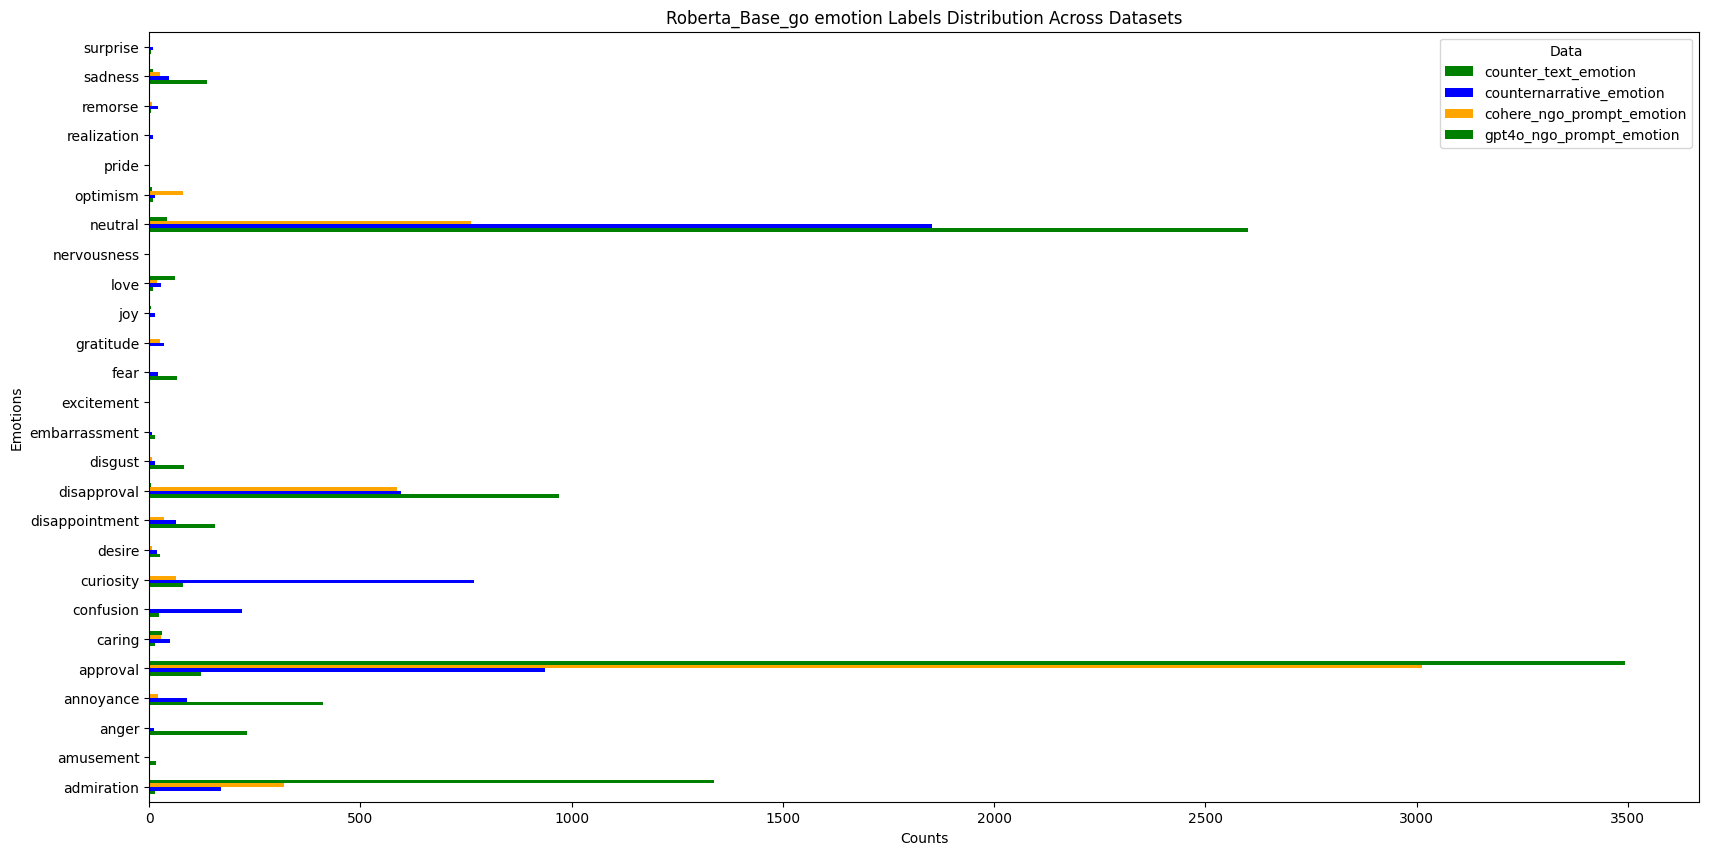


 plotting sankey charts



Saved counter - ngo dataset to : /content/drive/MyDrive/PhD with Rawat/milanlp/output/counter_ngo_emotion_analysis_df.csv




 +++++++++++++++++++ HATEEVAL - NGO +++++++++++++++++++++++++



<ipython-input-3-33b06adb42b8>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-33b06adb42b8>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 plotting word distribution



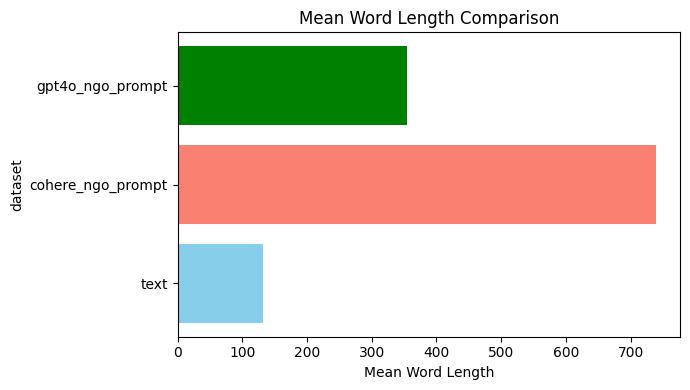


 plotting stats and emotions distribution



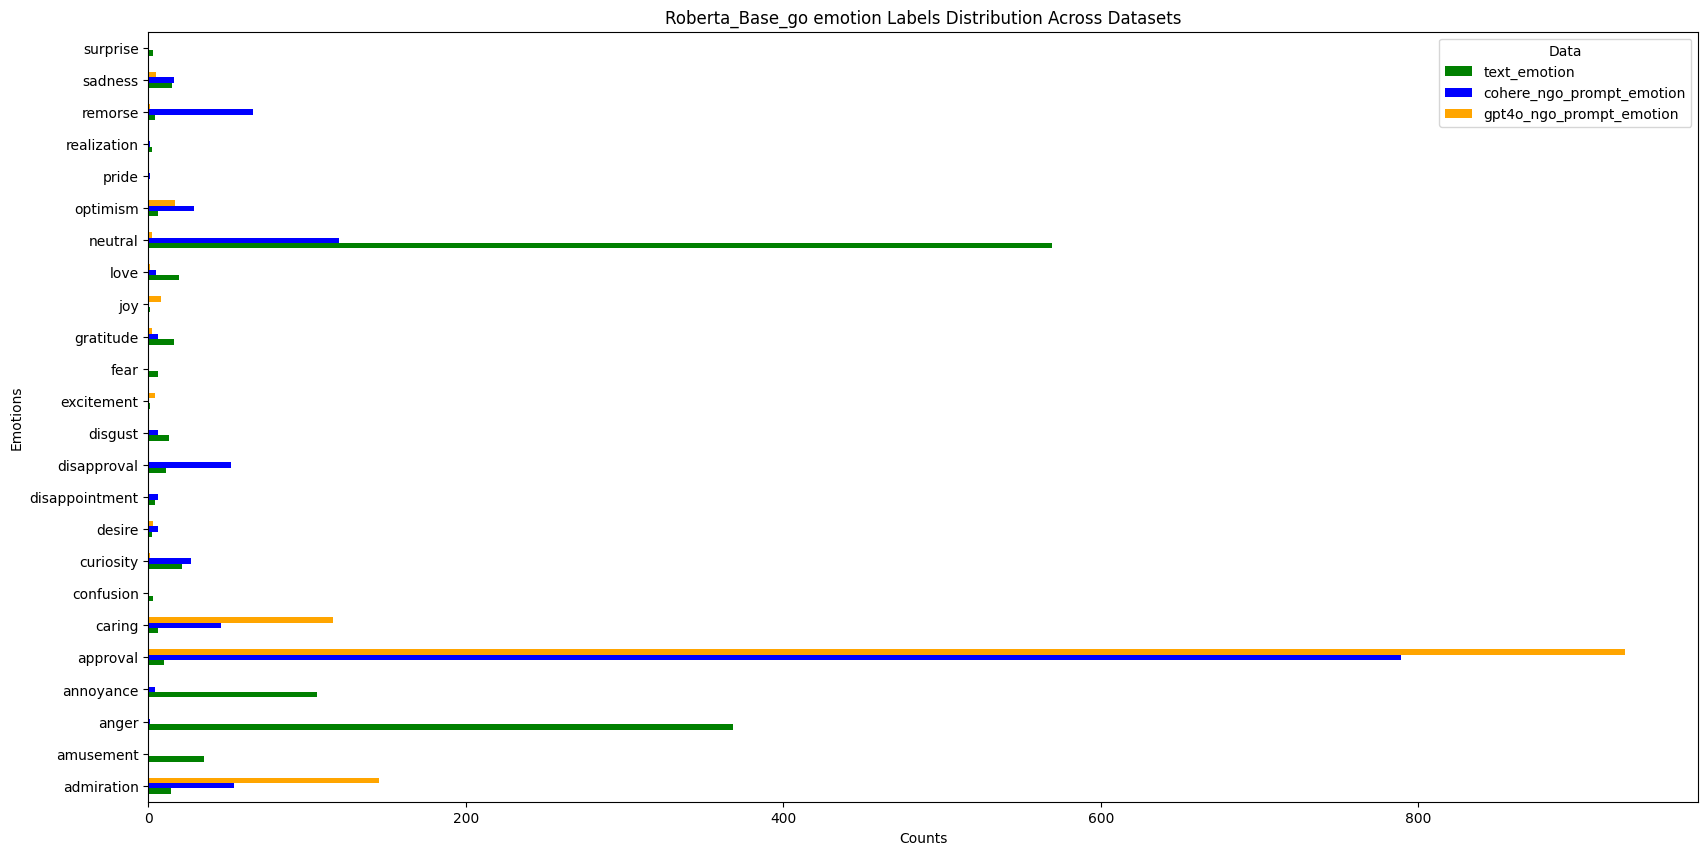


 plotting sankey charts



Saved hateeval - ngo dataset to : /content/drive/MyDrive/PhD with Rawat/milanlp/output/hateeval_ngo_emotion_analysis_df.csv




 +++++++++++++++++++ COUNTER - VANILLA +++++++++++++++++++++++++



<ipython-input-3-33b06adb42b8>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-33b06adb42b8>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-33b06adb42b8>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-debb5dfd


 plotting word distribution



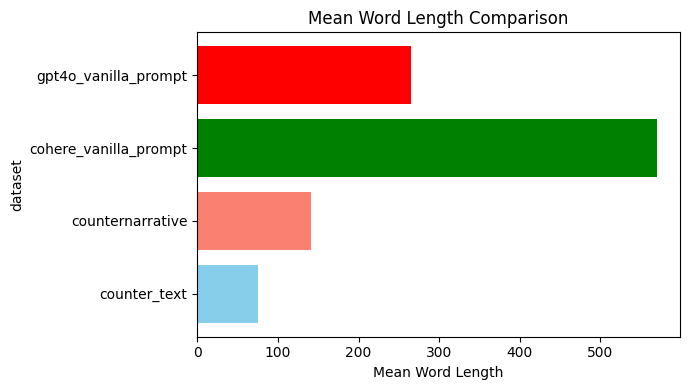


 plotting stats and emotions distribution



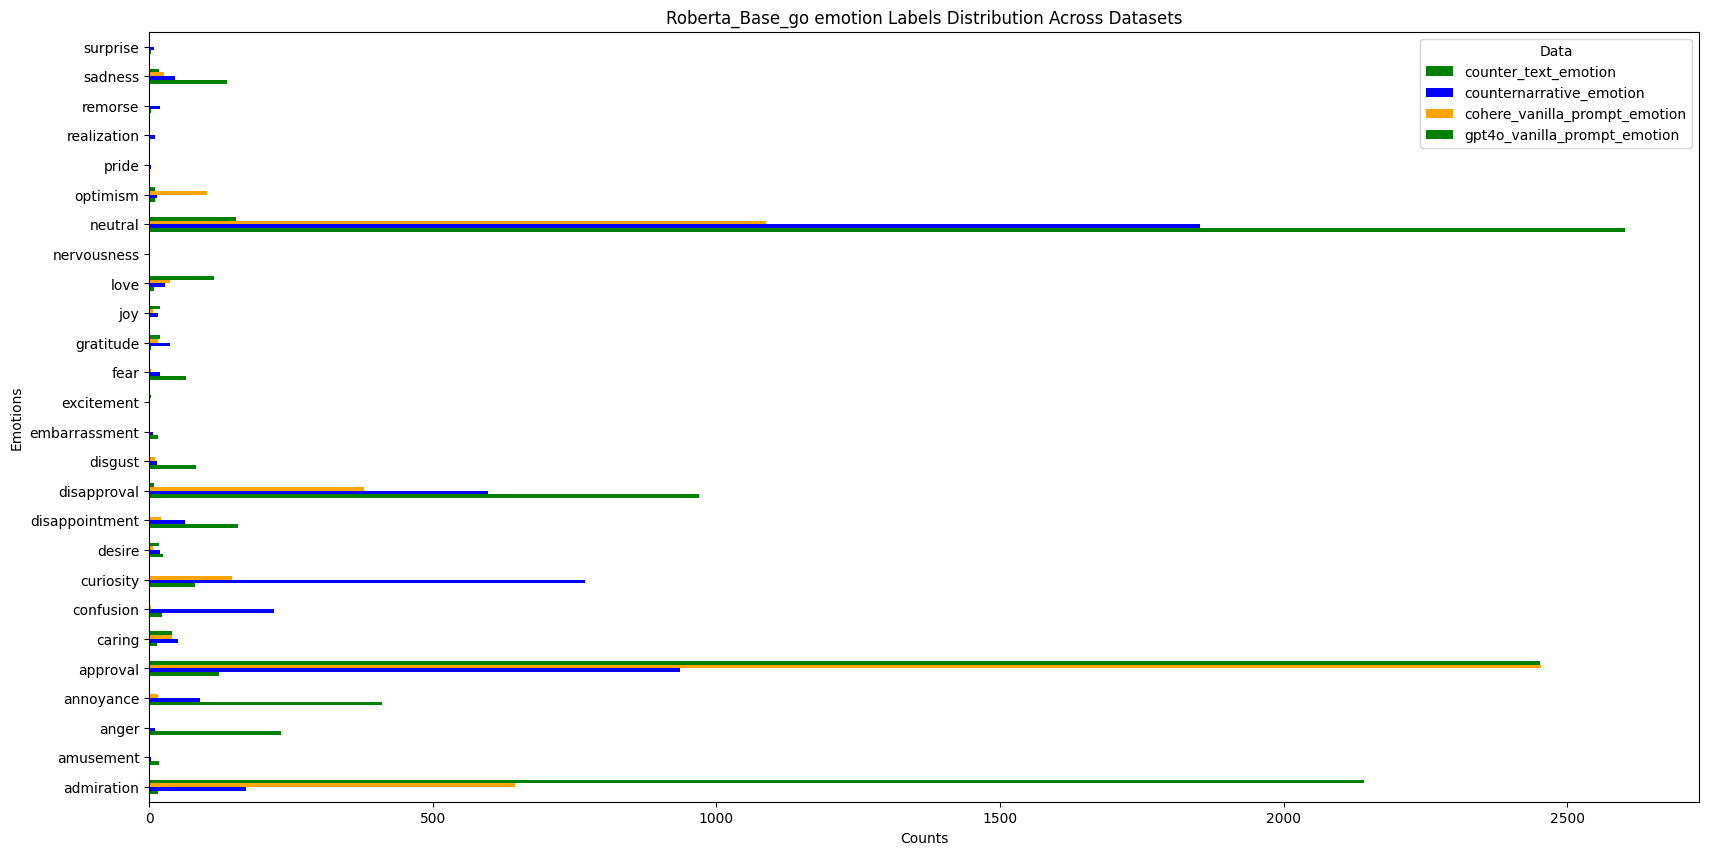


 plotting sankey charts



Saved counter - vanilla dataset to : /content/drive/MyDrive/PhD with Rawat/milanlp/output/counter_vanilla_emotion_analysis_df.csv




 +++++++++++++++++++ HATEEVAL - VANILLA +++++++++++++++++++++++++



<ipython-input-3-33b06adb42b8>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-3-33b06adb42b8>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 plotting word distribution



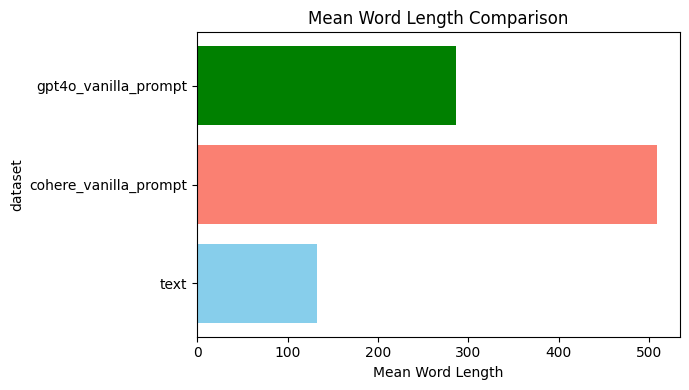


 plotting stats and emotions distribution



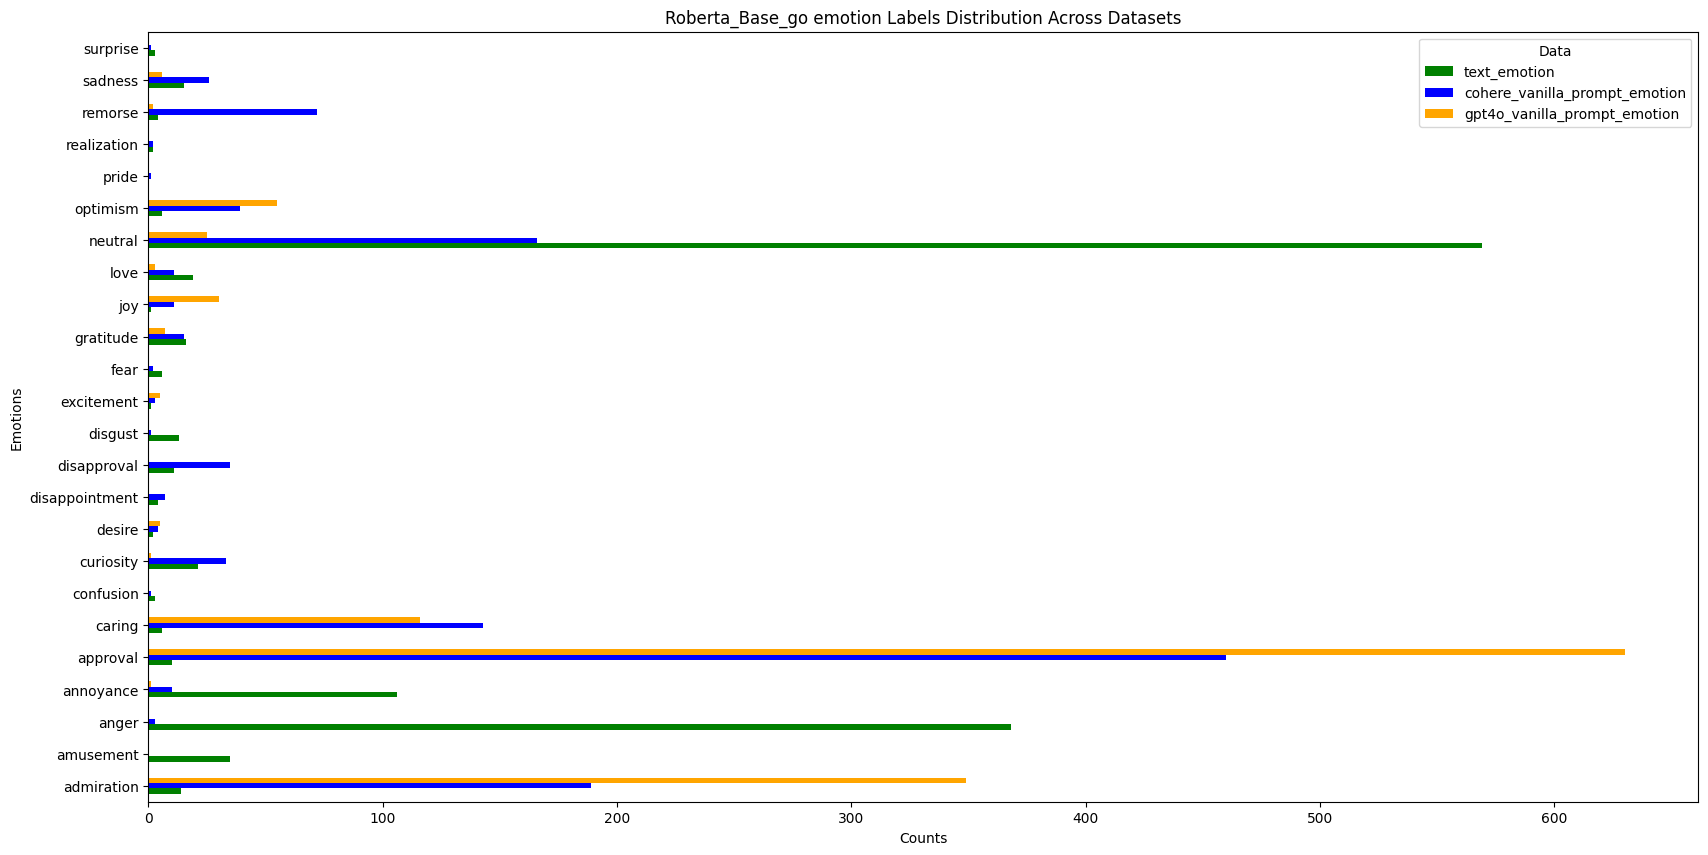


 plotting sankey charts



Saved hateeval - vanilla dataset to : /content/drive/MyDrive/PhD with Rawat/milanlp/output/hateeval_vanilla_emotion_analysis_df.csv



In [5]:
import random
new_analysis = '/content/drive/MyDrive/PhD with Rawat/milanlp/output'
if __name__ == "__main__":
    emotion = BERTemotion()
    stats = Stats()
    #counter
    counter_df= pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/analysis/final_counter_cohere_gpt4o_prompt.csv')
    #hateeval
    hate_eval_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/analysis/final_hateeval_cohere_gpt4o_prompt.csv')

    dataset_cases = [('counter', counter_df), ('hateeval', hate_eval_df)]
    personae = ['ngo', 'vanilla']

    for persona in personae:
        for dataset_name, dataset in dataset_cases:
            print(f"\n\n\n +++++++++++++++++++ {dataset_name.upper()} - {persona.upper()} +++++++++++++++++++++++++\n")
            expected_cols = ['text', 'counter_text', 'counternarrative', f'cohere_{persona}_prompt', f'gpt4o_{persona}_prompt']
            col_names = [col for col in expected_cols if col in dataset.columns]
            # dataset = dataset[col_names].sample(n=5, random_state=42)
            dataset = dataset[col_names]
            emotion_columns = []
            for item in col_names:
                stats.exploratory_data_analysis(dataset,item)
                dataset_emotion = emotion.predict(dataset[item].tolist())
                dataset[f"{item}_emotion"] = [result['emotion'] for result in dataset_emotion]
                dataset[f"{item}_score"] = [result['emotion_score'] for result in dataset_emotion]
                emotion_columns.append(f"{item}_emotion")
            print("\n plotting word distribution\n")
            stats.plot_mean_word_length(dataset, col_names, f'{dataset_name}_mean_word_distr_hateeval_{persona}.png')
            print("\n plotting stats and emotions distribution\n")
            emotion.plot_emotion_distribution(dataset, emotion_columns=emotion_columns, image_name =f'{dataset_name}_emotion_distr_{dataset_name}_{persona}.png')
            print("\n plotting sankey charts\n")
            for col in col_names:
                emotion.create_sankey_chart(dataset[f"{col}_emotion"], dataset_name, col)
                # update for ngo or vanilla accordingly
            file_name = f'{dataset_name}_{persona}_emotion_analysis_df.csv'
            file_path = os.path.join(new_analysis, file_name)
            dataset.to_csv(file_path, index=False)
            print(f"Saved {dataset_name} - {persona} dataset to : {file_path}\n")

# Part 2b. Calculating refusal rates for both dataset

In [15]:
import re
pd.options.display.max_colwidth = 500 # limit to the lenght of token that should be displayed on the daatsets


hate_vanilla = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/output/hateeval_vanilla_emotion_analysis_df.csv')
counter_vanilla = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/output/counter_vanilla_emotion_analysis_df.csv')
hate_ngo = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/output/hateeval_ngo_emotion_analysis_df.csv')
counter_ngo = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/output/counter_ngo_emotion_analysis_df.csv')


refusal_patterns_2 = [
    r"as an? (AI|sophisticated AI|language model|chatbot),? i (cannot|will not|am not able to)",
    r"this (is|falls) outside my (capabilities|abilities|training|ethical guidelines)",
    r"(i|we) (do not|cannot|will not) condone or support (hateful|offensive|harmful|discriminatory) content",
    r"(my|As an? AI|language model|chatbot) ",
    r"(sorry|i'm sorry),? but i (can't|cannot|won't) ",
]

important_patterns = [
    r"(it'?s |is) important to (approach|recognize|remember|focus|base)"
]


cols_interest = ['cohere_ngo_prompt', 'gpt4o_ngo_prompt', 'cohere_vanilla_prompt', 'gpt4o_vanilla_prompt']
datasets = [
    (hate_vanilla, 'HateEval_vanilla' ),
    (counter_vanilla, 'Counter_vanilla'),
    (hate_ngo, 'HateEval_ngo' ),
    (counter_ngo, 'Counter_ngo'),
]

# Function to detect refusals using regex
def is_refusal_regex(response):
    if pd.isna(response) or not isinstance(response, str):
        return False
    return any(re.search(pattern, response.lower()) for pattern in refusal_patterns_2)

# Function to detect is_importance using regex
def is_important_regex(response):
    if pd.isna(response) or not isinstance(response, str):
        return False
    return any(re.search(pattern, response.lower()) for pattern in important_patterns)


for dataset ,dataset_name in datasets:
  print(f"\n +++++++++++++++++++ {dataset_name.upper()} +++++++++++++++++++++++++\n")
  new_col  = [col for col in cols_interest if col in dataset.columns]
  for col in new_col:
      #refusal
      dataset[f'is_refusal_{col}'] = dataset[col].apply(is_refusal_regex)
      refusal_count = dataset[f'is_refusal_{col}'].sum()
      total_samples = len(dataset)
      refusal_rate = (refusal_count / total_samples) * 100
      #importance
      dataset[f'is_important_{col}'] = dataset[col].apply(is_important_regex)
    # Calculate refusal rate
      importance_count = dataset[f'is_important_{col}'].sum()
      total_samples = len(dataset)
      importance_rate = (importance_count / total_samples) * 100

      print(f"The refusal rate for {col} is approximately {refusal_rate:.3f}%")
      print(f"The importance rate for {col} is approximately {importance_rate:.3f}%\n")


 +++++++++++++++++++ HATEEVAL_VANILLA +++++++++++++++++++++++++

The refusal rate for cohere_vanilla_prompt is approximately 16.356%
The importance rate for cohere_vanilla_prompt is approximately 3.239%

The refusal rate for gpt4o_vanilla_prompt is approximately 3.482%
The importance rate for gpt4o_vanilla_prompt is approximately 0.162%


 +++++++++++++++++++ COUNTER_VANILLA +++++++++++++++++++++++++

The refusal rate for cohere_vanilla_prompt is approximately 4.318%
The importance rate for cohere_vanilla_prompt is approximately 1.459%

The refusal rate for gpt4o_vanilla_prompt is approximately 3.639%
The importance rate for gpt4o_vanilla_prompt is approximately 0.660%


 +++++++++++++++++++ HATEEVAL_NGO +++++++++++++++++++++++++

The refusal rate for cohere_ngo_prompt is approximately 13.117%
The importance rate for cohere_ngo_prompt is approximately 7.126%

The refusal rate for gpt4o_ngo_prompt is approximately 1.296%
The importance rate for gpt4o_ngo_prompt is approximately 0.081%


# Checking emotions per important and refusal rates

In [31]:
datasets = [
    (hate_vanilla, 'HateEval_vanilla' ),
    (counter_vanilla, 'Counter_vanilla'),
    (hate_ngo, 'HateEval_ngo' ),
    (counter_ngo, 'Counter_ngo'),
]

cols_interest_2 = ['text', 'counter_text', 'cohere_ngo_prompt', 'gpt4o_ngo_prompt', 'cohere_vanilla_prompt',
                 'gpt4o_vanilla_prompt', 'cohere_ngo_prompt_emotion', 'gpt4o_ngo_prompt_emotion',
                 'cohere_vanilla_prompt_emotion', 'gpt4o_vanilla_prompt_emotion']

highest_important = ["cohere_vanilla_prompt", "cohere_ngo_prompt", 'gpt4o_vanilla_prompt', 'gpt4o_ngo_prompt']

for dataset, dataset_names in datasets:
  print(f"\n +++++++++++++++++++ {dataset_names.upper()} +++++++++++++++++++++++++\n")
  new_col  = [col for col in cols_interest_2 if col in dataset.columns]
  for highest in highest_important:
      if highest in new_col:
        data = dataset[dataset[f'is_important_{highest}'] == True][new_col]
        print(data[f"{highest}_emotion"].value_counts())


 +++++++++++++++++++ HATEEVAL_VANILLA +++++++++++++++++++++++++

cohere_vanilla_prompt_emotion
approval      21
admiration     5
caring         4
optimism       3
remorse        3
neutral        2
sadness        1
gratitude      1
Name: count, dtype: int64
gpt4o_vanilla_prompt_emotion
approval    2
Name: count, dtype: int64

 +++++++++++++++++++ COUNTER_VANILLA +++++++++++++++++++++++++

cohere_vanilla_prompt_emotion
approval       33
neutral        20
disapproval     7
sadness         4
optimism        4
caring          2
fear            1
curiosity       1
admiration      1
Name: count, dtype: int64
gpt4o_vanilla_prompt_emotion
approval       19
admiration      5
sadness         4
neutral         2
disapproval     2
caring          1
Name: count, dtype: int64

 +++++++++++++++++++ HATEEVAL_NGO +++++++++++++++++++++++++

cohere_ngo_prompt_emotion
approval       66
remorse         6
neutral         5
disapproval     4
optimism        2
sadness         2
annoyance       1
caring       

# Part 3: Analysis Counterspeech dataset

### Analysing the relationship between the emotion (Amandas suggestion)


The goal here is to asses the discrepanacies in emotions distributions compared to the original hate speech emotion.

question: what are the models emotion for the GO person when the original hate speech sentiment is either 'neutral', 'approval', 'disapproval' and 'admiration'. These emotions were chosen primarily becaus ethey are the most prominent from our charts above.

In [32]:
vanilla_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/analysis/analysis_vanilla_df.csv')
ngo_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/analysis/analysis_ngo_df.csv')

base_emotions = ngo_df[['hate_speech', 'hate_speech_emotion','ngo_counternarrative', 'ngo_counternarrative_emotion']]
ngo_emotions = ngo_df[['cohere_ngo_persona', 'cohere_ngo_persona_emotion', 'gpt4o_ngo_persona', 'gpt4o_ngo_persona_emotion']]
vanilla_emotions = vanilla_df[['cohere_vanilla_persona', 'cohere_vanilla_persona_emotion', 'gpt4o_vanilla_persona', 'gpt4o_vanilla_persona_emotion']]

emotions_df = pd.concat([base_emotions, ngo_emotions, vanilla_emotions], axis=1)

In [34]:
emotion = BERTemotion()

def filter_by_emotion(dataset, main_column, emotion_label, column_of_interest):
    return dataset.loc[dataset[main_column] == emotion_label, column_of_interest].reset_index(drop=True)

emotion_labels = ['annoyance', 'approval', 'disapproval', 'admiration']
personae = ['ngo','vanilla']
main_column = 'hate_speech_emotion'
dataset_cases = {
        'ngo' : ngo_emotions,
        'vanilla' : vanilla_emotions
      }

for persona in personae:
  for emotion_label in emotion_labels:
      cols = [f'cohere_{persona}_persona', f'cohere_{persona}_persona']
      dataset = filter_by_emotion(emotions_df, main_column, emotion_label, dataset_cases.get(persona).columns)
      dataset.columns
      for col in cols:
          emotion.create_sankey_chart(dataset[f"{col}_emotion"], 'some_name', col)

Device set to use cpu


# Stop here for now

Device set to use cpu





 +++++++++++++++++++ ngo +++++++++++++++++++++++++


 plotting word distribution



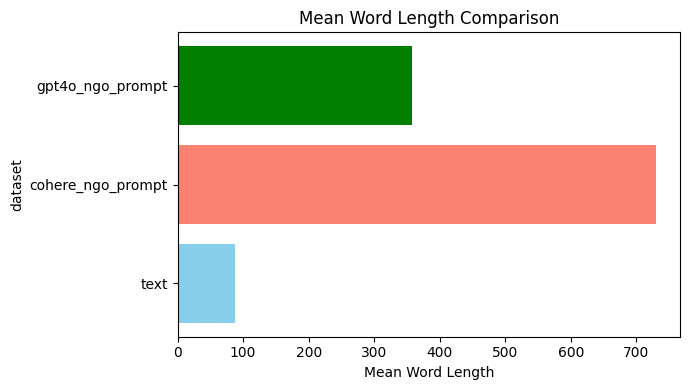


 plotting stats and emotions distribution



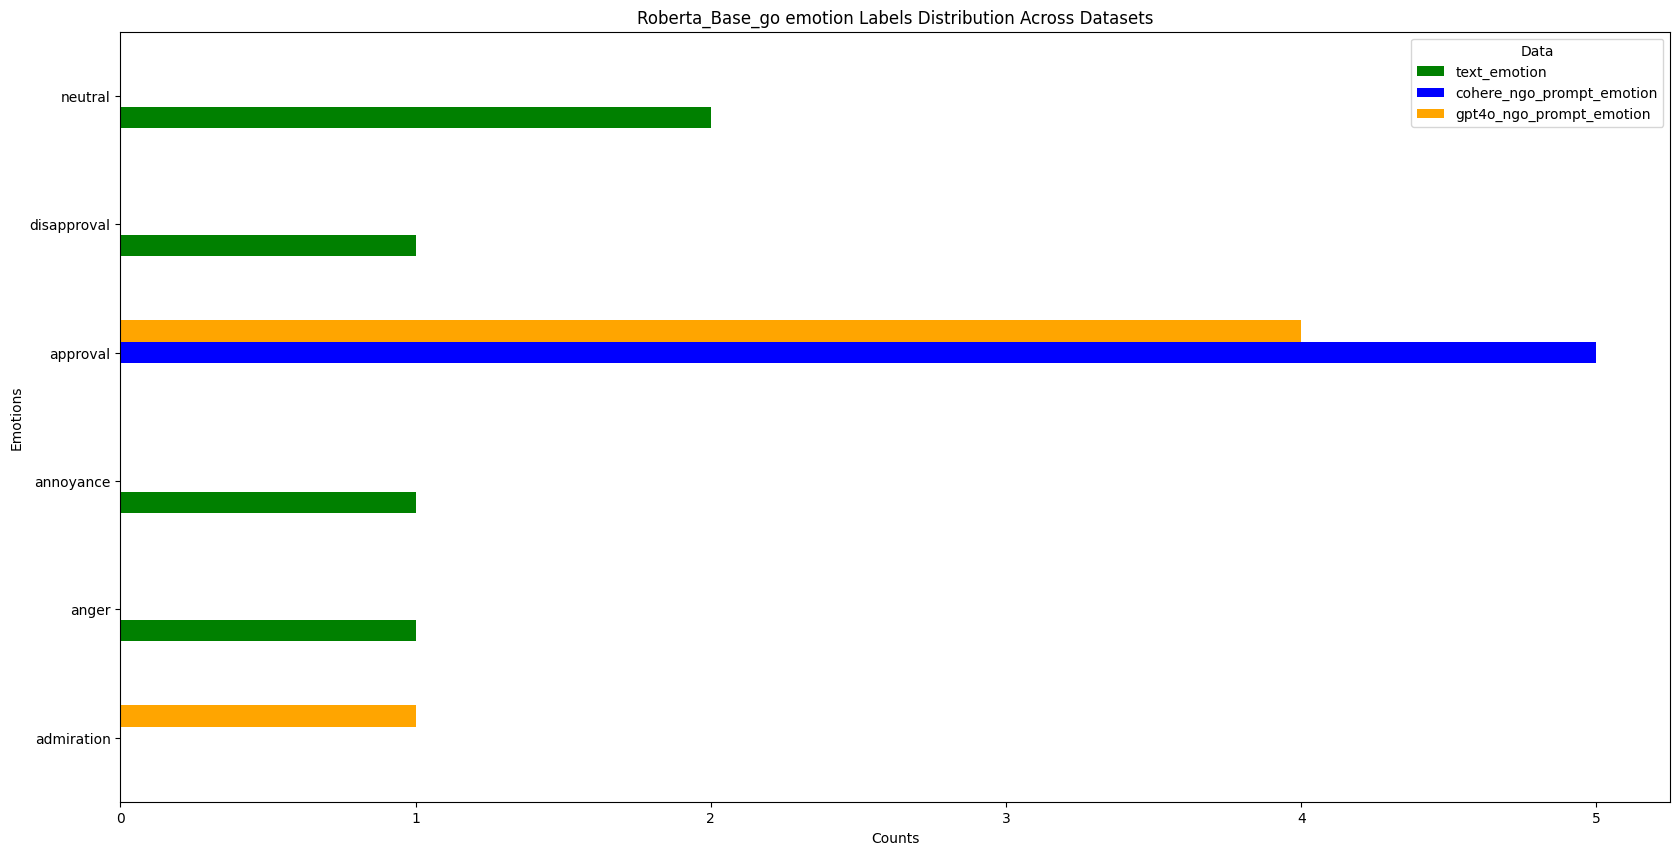


 plotting sankey charts






 +++++++++++++++++++ vanilla +++++++++++++++++++++++++


 plotting word distribution



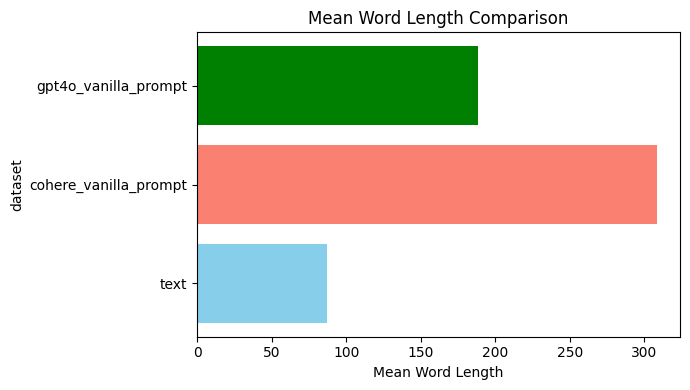


 plotting stats and emotions distribution



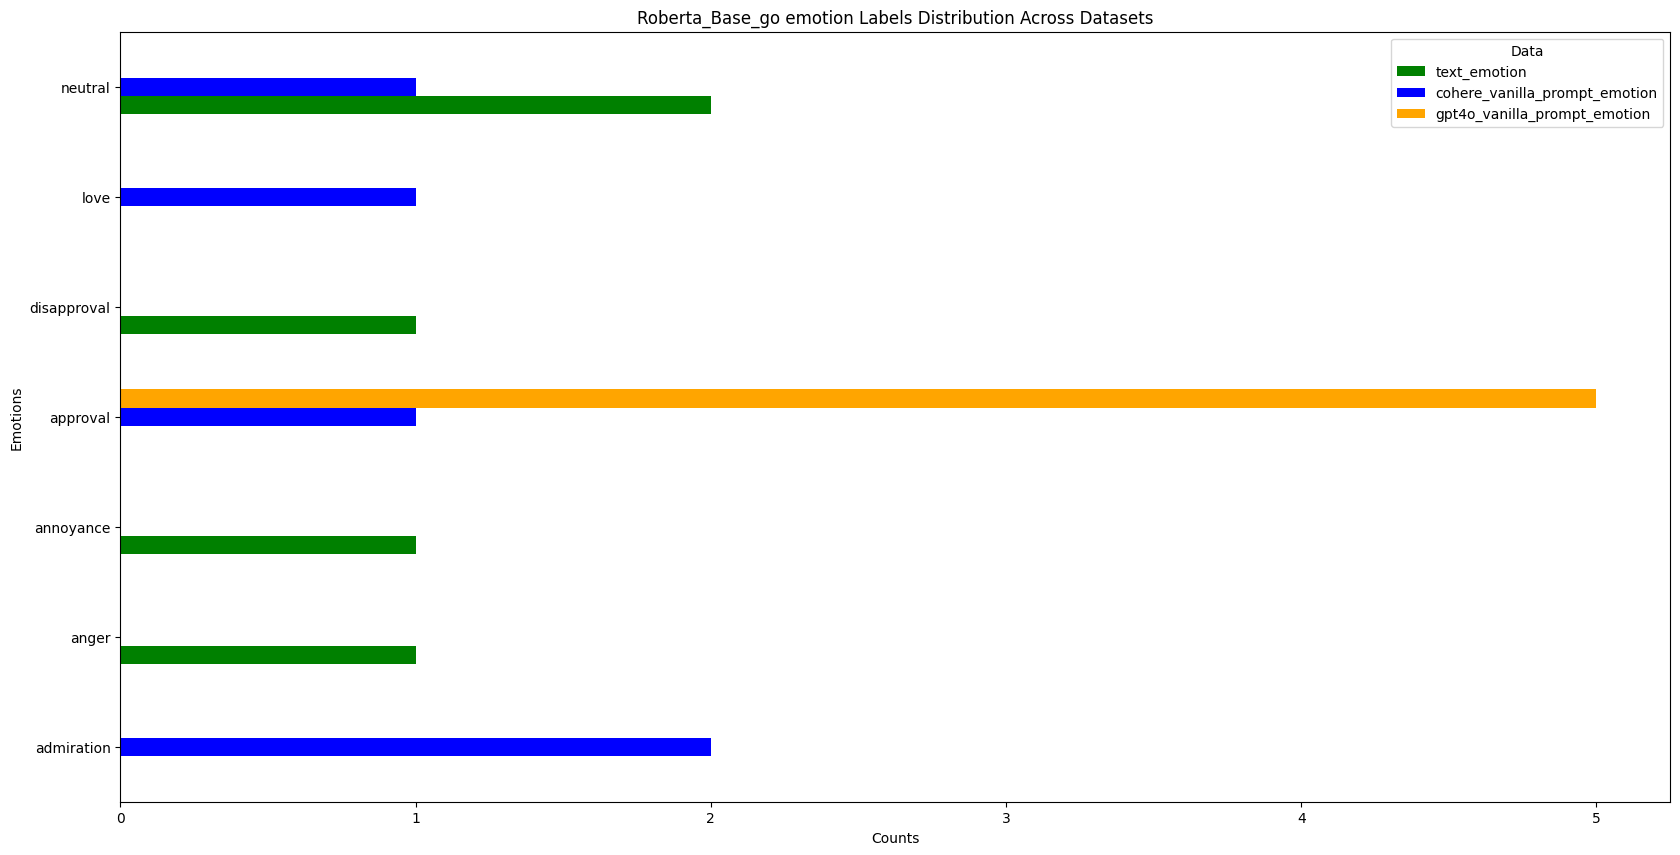


 plotting sankey charts



In [5]:
emotion = BERTemotion()
stats = Stats()

#hateeval
hate_eval_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/analysis/final_hateeval_cohere_gpt4o_prompt.csv')
# dataset = ['hateeval', 'counter']
personae = [('ngo', 'prompt'), ('vanilla', 'prompt')]
for persona, name in personae:
    print(f"\n\n\n +++++++++++++++++++ {persona} +++++++++++++++++++++++++\n")
    col_names = ['text', f'cohere_{persona}_{name}', f'gpt4o_{persona}_{name}']
    # dataset = hate_eval_df[col_names]
    dataset = hate_eval_df[col_names].sample(n=5, random_state=42).reset_index(drop=True)
    emotion_columns = []
    for item in col_names:
        stats.exploratory_data_analysis(dataset,item)
        dataset_emotion = emotion.predict(dataset[item].tolist())
        dataset[f"{item}_emotion"] = [result['emotion'] for result in dataset_emotion]
        dataset[f"{item}_score"] = [result['emotion_score'] for result in dataset_emotion]
        emotion_columns.append(f"{item}_emotion")
    print("\n plotting word distribution\n")
    stats.plot_mean_word_length(dataset, col_names, f'mean_word_distr_hateeval_{persona}.png')
    print("\n plotting stats and emotions distribution\n")
    emotion.plot_emotion_distribution(dataset, emotion_columns=emotion_columns, image_name =f'emotion_distr_hateeval_{persona}.png')
    print("\n plotting sankey charts\n")
    for col in col_names:
        emotion.create_sankey_chart(dataset[f"{col}_emotion"], col)

        # update for ngo or vanilla accordingly
    file_name = f'hateeval_{persona}_emotion_analysis_df.csv'
    file_path = os.path.join(analysis_path, file_name)
    dataset.to_csv(file_path, index=False)


##################################################




 +++++++++++++++++++ vanilla +++++++++++++++++++++++++



<ipython-input-9-c5a196c09e34>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-c5a196c09e34>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 plotting word distribution



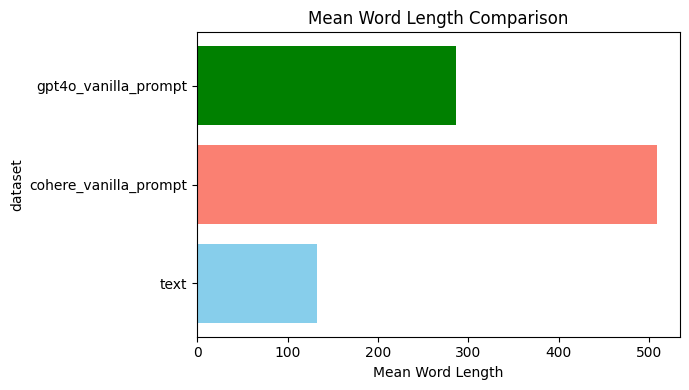


 plotting stats and emotions distribution



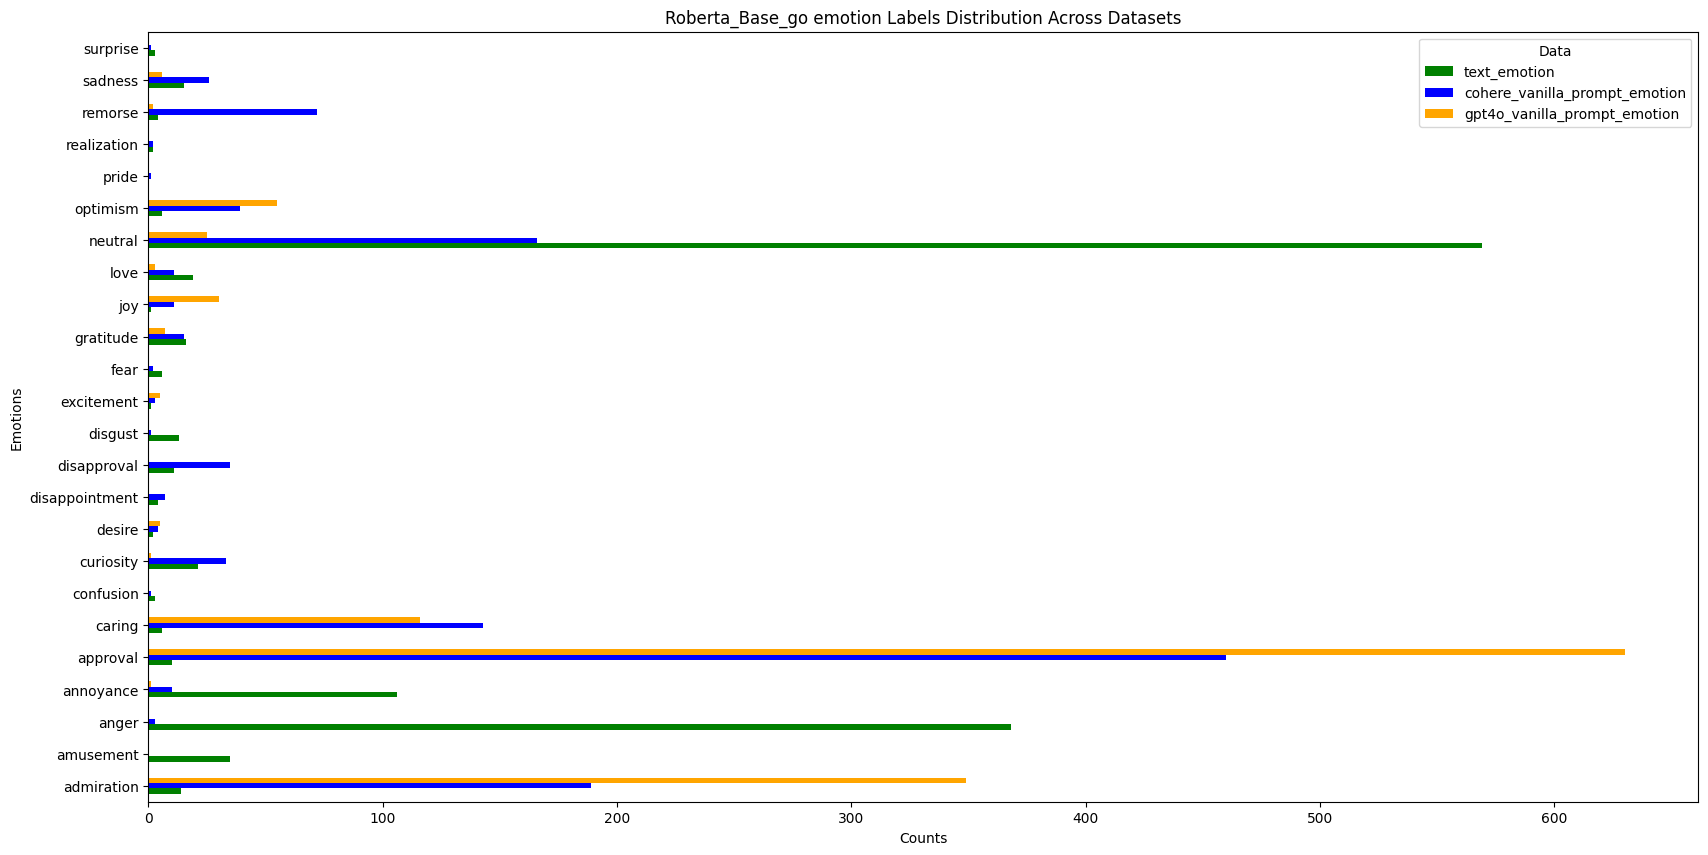


 plotting sankey charts



In [69]:
hate_eval_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/analysis/final_hateeval_cohere_gpt4o_prompt.csv')
personae = [('vanilla', 'prompt')]
for persona, name in personae:
  print(f"\n\n\n +++++++++++++++++++ {persona} +++++++++++++++++++++++++\n")
  col_names = ['text', f'cohere_{persona}_{name}', f'gpt4o_{persona}_{name}']
  dataset = hate_eval_df[col_names]
  emotion_columns = []
  for item in col_names:
      stats.exploratory_data_analysis(dataset,item)
      dataset_emotion = emotion.predict(dataset[item].tolist())
      dataset[f"{item}_emotion"] = [result['emotion'] for result in dataset_emotion]
      dataset[f"{item}_score"] = [result['emotion_score'] for result in dataset_emotion]
      emotion_columns.append(f"{item}_emotion")
  print("\n plotting word distribution\n")
  stats.plot_mean_word_length(dataset, col_names, f'mean_word_distr_hateeval_{persona}.png')
  print("\n plotting stats and emotions distribution\n")
  emotion.plot_emotion_distribution(dataset, emotion_columns=emotion_columns, image_name =f'emotion_distr_hateeval_{persona}.png')
  print("\n plotting sankey charts\n")
  for col in col_names:
      emotion.create_sankey_chart(dataset[f"{col}_emotion"], col)

      #update for ngo or vanilla accordingly
  file_path = os.path.join(analysis_path, 'hateeval_vanilla_emotion_analysis_df.csv')
  counter_ngo_df.to_csv(file_path, index=False)


In [ ]:
!pip install cohere --quiet

import cohere

os.environ["COHERE_PROD"] = userdata.get("COHERE_PROD")

# api_key = userdata.get("OPENAI_KEY")


class Cohere_ai:
   def prompt_counter(self, event, model_name= 'command'):
    prompt = f"generate a counter-narrative to this hateful comment '{event}'. omit explanations and provide only the counter narrative"
    co_api = cohere.Client(userdata.get("COHERE_API"))
    response = co_api.chat(
        message=prompt,
        model=model_name,
        temperature=0.3
    )
    return response.text

cohere_ai = Cohere_ai()

event = 'The feminist theory makes no sense. It is about equality, for women only.'
cohere_ai.prompt_counter(event, model_name= 'command')
# cohere_prompt = prompt_counter()
# cohere_prompt(event, co_model)


In [11]:
import random
if __name__ == "__main__":
    emotion = BERTemotion()
    stats = Stats()

    counter_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/gpt4o_cohere_vanilla_prompt.csv')
    # columns = ['HATE_SPEECH', 'COUNTER_NARRATIVE', 'Cohere_prompt', 'model_completion']
    # new_name = ['hate_speech', 'vanilla_counternarrative', 'cohere_vanilla_prompt', 'gpt4o_vanilla_prompt']
    # # Rename columns
    # rename_dict = dict(zip(columns, new_name))
    # counter_ngo_df.rename(columns=rename_dict, inplace=True)

    personae = [('ngo', 'persona'), ('vanilla', 'persona')]
    for persona, name in personae:
        print(f"\n\n\n +++++++++++++++++++ {persona} +++++++++++++++++++++++++\n")
        col_names = ['text', f'cohere_{persona}_{name}', f'gpt4o_{persona}_{name}']

        counter_ngo_df = counter_ngo_df[new_name]
        # counter_ngo_df = counter_ngo_df[new_name].sample(n=200, random_state=42).reset_index(drop=True)

        print(f'the shape of my current sample is {counter_ngo_df.shape}')
        emotion_columns = []
        for item in new_name:
            stats.exploratory_data_analysis(counter_ngo_df,item)
            counter_ngo_df_emotion = emotion.predict(counter_ngo_df[item].tolist())
            counter_ngo_df[f"{item}_emotion"] = [result['emotion'] for result in counter_ngo_df_emotion]
            counter_ngo_df[f"{item}_score"] = [result['emotion_score'] for result in counter_ngo_df_emotion]
            emotion_columns.append(f"{item}_emotion")

        stats.plot_mean_word_length(counter_ngo_df, new_name, 'counter_mean_word_distri.png')
        emotion.plot_emotion_distribution(counter_ngo_df, emotion_columns=emotion_columns, image_name ='counter_emotion_distri.png')

        print("\n plotting the sankey charts for the emotions in each columns\n")

        for col in new_name:
            emotion.create_sankey_chart(counter_ngo_df[f"{col}_emotion"], col)

            #update for ngo or vanilla accordingly
        file_path = os.path.join(analysis_path, 'analysis_vanilla_df.csv')
        counter_ngo_df.to_csv(file_path, index=False)


Device set to use cpu


the shape of my current sample is (5002, 4)


KeyboardInterrupt: 

In [ ]:
def prompt_counter(event, model_name= 'command'):
    prompt = f"generate a counter-narrative to this hateful comment '{event}'. omit explanations and provide only the counter narrative"
    co_api = cohere.Client(userdata.get("COHERE_API"))
    response = co_api.chat(
        message=prompt,
        model=model_name,
        temperature=0.3
    )
    return response.text

co_model = 'command'
event = 'The feminist theory makes no sense. It is about equality, for women only.'
prompt_counter(event = event, model_name = co_model)
